# Коллаборативная фильтрация

U - множество субъектов (клиентов, пользователей: users)     
R - множество объектов (ресурсов, товаров, предметов: items)     
Y - пространство описаний транзакций  

$$
D = (u_i, r_i, y_i)^m_{i=1} \in U \times R \times Y \textrm {- транзакционные данные}
$$ 

### Агрегированные данные  
$$
F = \begin{Vmatrix} 
f_{ur}
\end{Vmatrix} \textrm {- матрица кросс-табуляции размера} \begin{vmatrix} U \end{vmatrix} \times  \begin{vmatrix} R \end{vmatrix} \\
где\quad f_{ur} = aagr\left\{(u_i, r_i, y_i) \in D | u_i = u, r_i = r \right\}
$$

### Задачa
$$ \textrm {Прогнозирование незаполненных ячеек} f_{ur}$$


In [1]:
!pip install pyspark py4j==0.10.7 sparkmonitor pandas
!pip3 install -U matplotlib numpy --user
!pip install --upgrade jupyter ipython
import os
os.environ['PYSPARK_PYTHON'] = '/usr/bin/python'

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: matplotlib in /Users/echuraev/Library/Python/3.7/lib/python/site-packages (3.0.2)
Requirement already up-to-date: numpy in /Users/echuraev/Library/Python/3.7/lib/python/site-packages (1.15.4)
Requirement already up-to-date: jupyter in /usr/local/lib/python2.7/site-packages (1.0.0)
Requirement already up-to-date: ipython in /usr/local/lib/python2.7/site-packages (5.8.0)
Requirement not upgraded as not directly required: nbconvert in /usr/local/lib/python2.7/site-packages (from jupyter) (5.4.0)
Requirement not upgraded as not directly required: jupyter-console in /usr/local/lib/python2.7/site-packages (from jupyter) (5.2.0)
Requirement not upgraded as not directly required: qtconsole in /usr/local/lib/python2.7/site-packages (from jupyter) (4.4.3)
Requirement not upgraded as not directly required: ipykernel in /usr

Requirement not upgraded as not directly required: jsonschema!=2.5.0,>=2.4 in /usr/local/lib/python2.7/site-packages (from nbformat>=4.4->nbconvert->jupyter) (2.6.0)
Requirement not upgraded as not directly required: python-dateutil>=2.1 in /Users/echuraev/Library/Python/2.7/lib/python/site-packages (from jupyter-client->jupyter-console->jupyter) (2.7.3)
Requirement not upgraded as not directly required: singledispatch in /usr/local/lib/python2.7/site-packages (from tornado>=4.0->ipykernel->jupyter) (3.4.0.3)
Requirement not upgraded as not directly required: futures in /usr/local/lib/python2.7/site-packages (from tornado>=4.0->ipykernel->jupyter) (3.2.0)
Requirement not upgraded as not directly required: backports-abc>=0.4 in /usr/local/lib/python2.7/site-packages (from tornado>=4.0->ipykernel->jupyter) (0.5)
Requirement not upgraded as not directly required: functools32; python_version == "2.7" in /usr/local/lib/python2.7/site-packages (from jsonschema!=2.5.0,>=2.4->nbformat>=4.4->nb

In [1]:
import pandas as pd
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row, functions
from pyspark.sql.types import *
from pyspark.sql.functions import first
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.ml.classification import *
import matplotlib.pyplot as plt
import numpy as np
from numpy import array

In [2]:
import sparkmonitor
!jupyter nbextension install sparkmonitor --py --user --symlink 
!jupyter nbextension enable sparkmonitor --py --user            
!jupyter serverextension enable --py --user sparkmonitor
!ipython profile create && echo "c.InteractiveShellApp.extensions.append('sparkmonitor.kernelextension')" >>  $(ipython profile locate default)/ipython_kernel_config.py

Installing /usr/local/lib/python3.7/site-packages/sparkmonitor/static -> sparkmonitor
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable sparkmonitor --user --py
    
Enabling notebook extension sparkmonitor/module...
      - Validating: OK
Enabling: sparkmonitor.serverextension
- Writing config: /Users/echuraev/.jupyter
    - Validating...
      sparkmonitor.serverextension  OK


In [3]:
conf.setAppName('recommender')
conf.setMaster('local[*]').set("spark.sql.shuffle.partitions", "8")
print(conf.toDebugString())

spark.extraListeners=sparkmonitor.listener.JupyterSparkMonitorListener
spark.driver.extraClassPath=/usr/local/lib/python3.7/site-packages/sparkmonitor/listener.jar
spark.app.name=recommender
spark.master=local[*]
spark.sql.shuffle.partitions=8


In [4]:
sc = SparkContext.getOrCreate(conf=conf)
spark = SparkSession(sc)

In [5]:
schema=StructType([
    StructField("user_id", IntegerType(), True),
    StructField("item_id", IntegerType(), True),
    StructField("rating", IntegerType(), True),
    StructField("timestamp", IntegerType(), True)],
    )
df = spark.read.csv("u.data",sep="\\t",schema=schema)

df.show()

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|    196|    242|     3|881250949|
|    186|    302|     3|891717742|
|     22|    377|     1|878887116|
|    244|     51|     2|880606923|
|    166|    346|     1|886397596|
|    298|    474|     4|884182806|
|    115|    265|     2|881171488|
|    253|    465|     5|891628467|
|    305|    451|     3|886324817|
|      6|     86|     3|883603013|
|     62|    257|     2|879372434|
|    286|   1014|     5|879781125|
|    200|    222|     5|876042340|
|    210|     40|     3|891035994|
|    224|     29|     3|888104457|
|    303|    785|     3|879485318|
|    122|    387|     5|879270459|
|    194|    274|     2|879539794|
|    291|   1042|     4|874834944|
|    234|   1184|     2|892079237|
+-------+-------+------+---------+
only showing top 20 rows



In [6]:
dataset_count = df.groupBy('rating').count().collect()
sorted(dataset_count,key=lambda x : x['rating'])

[Row(rating=1, count=6110),
 Row(rating=2, count=11370),
 Row(rating=3, count=27145),
 Row(rating=4, count=34174),
 Row(rating=5, count=21201)]

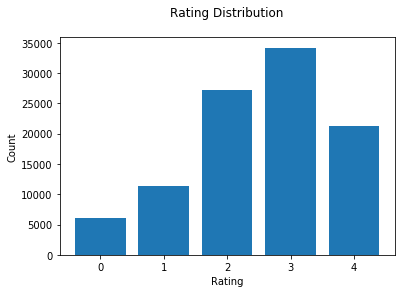

In [7]:
plt.rc("font", size=10)
plt.bar(np.arange(len(dataset_count)), [x['count'] for x in sorted(dataset_count,key=lambda x : x['rating'])])
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Data Preprocessing

Находим фильм, который оценило больше всего пользователей.
Строим матрицу кросс-табуляции, в которой столбец самого оцениваемого фильма будет считаться классом модели.

In [8]:
df.createOrReplaceTempView("df")
class_id=spark.sql("SELECT item_id, COUNT(user_id) FROM df GROUP BY item_id ORDER BY COUNT(user_id) DESC").first().item_id
class_id=str(class_id)
df=df.groupBy("user_id")\
    .pivot("item_id")\
    .agg(first("rating").cast("double"))\
    .repartition(class_id)\
    .fillna(0)\
    .drop("user_id")\
    .withColumnRenamed(class_id,"label")

#df.limit(5).toPandas()
print(df.rdd.getNumPartitions())

8


Собираем признаки в столбец "features", который будет иметь на выходе тип вектора.

In [9]:
assembler=VectorAssembler(
    inputCols=df.drop("label").columns,
    outputCol="features")
transformed = assembler.transform(df)

In [10]:
from pyspark import keyword_only  
from pyspark.ml.pipeline import Transformer  
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.linalg import SparseVector, DenseVector, VectorUDT
from pyspark.sql.functions import udf


class AsDenseTransformer(Transformer, HasInputCol, HasOutputCol):  
    @keyword_only
    def __init__(self, inputCol=None, outputCol=None):
        super(AsDenseTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, inputCol=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def _transform(self, dataset):
        out_col = self.getOutputCol()
        in_col = dataset[self.getInputCol()]

        asDense = udf(lambda s: DenseVector(s.toArray()), VectorUDT()) 

        return dataset.withColumn(out_col,  asDense(in_col))

In [11]:
transformer = AsDenseTransformer(inputCol="features",outputCol="features")

In [12]:
transformer = AsDenseTransformer(inputCol="features",outputCol="features")
dense=transformer.transform(transformed)

In [13]:
labeled=df.where("label > 0")
labeled = labeled.withColumn("label",labeled.label-1)
train,test=labeled.randomSplit([0.75,0.25])
print(train.count())
print(test.count())

446
137


# One-Vs-Rest

In [14]:
lr=LogisticRegression(maxIter=10)
ovr=OneVsRest(classifier=lr)
pip = Pipeline(stages=[assembler,transformer,ovr])
model=pip.fit(train)
result = model.transform(test)
result.count()

137

In [15]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
#evaluator=RegressionEvaluator(metricName="rmse")
print("Test error = %g" % (1.0-evaluator.evaluate(result)))

Test error = 0.489051


# Decision Trees

In [16]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")
pip = Pipeline(stages=[assembler,dt])
result = pip.fit(train).transform(test).select("label","prediction")
result.count()

137

In [17]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test error = %g" % (1.0-evaluator.evaluate(result)))

Test error = 0.40146


# Multinomial logistic regression

In [18]:
lr = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8, labelCol="label", featuresCol="features")
pip = Pipeline(stages=[assembler,lr])
result = pip.fit(train).transform(test).select("label","prediction")
result.show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
+-----+----------+
only showing top 10 rows



In [19]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test error = %g" % (1.0-evaluator.evaluate(result)))

Test error = 0.423358


# Multilayer Perceptron

In [20]:
layers = [1681,256,64,16,5] 

# create the trainer and set its parameters 
trainer = MultilayerPerceptronClassifier(maxIter=100,layers=layers) 


pip=Pipeline(stages=[assembler,trainer])
# train the model 
model = pip.fit(train) 

result = model.transform(test) 
predictionAndLabels = result.select("label", "prediction") 
predictionAndLabels.show(10)

+-----+----------+
|label|prediction|
+-----+----------+
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       3.0|
|  3.0|       3.0|
|  3.0|       4.0|
|  3.0|       3.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       2.0|
+-----+----------+
only showing top 10 rows



In [21]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test set accuracy = " + str(evaluator.evaluate(predictionAndLabels)))

Test set accuracy = 0.45985401459854014


# Naive Bayes

In [22]:
from pyspark.ml.classification import NaiveBayes 
nb = NaiveBayes(smoothing=1.0, modelType="multinomial") 

pip = Pipeline(stages=[assembler,nb]) 
result = pip.fit(train).transform(test).select("label","prediction")
result.count()

137

In [23]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy") 
print("Test error = %g" % (1.0-evaluator.evaluate(result))) 
result.show(10)

Test error = 0.605839
+-----+----------+
|label|prediction|
+-----+----------+
|  3.0|       4.0|
|  3.0|       3.0|
|  3.0|       3.0|
|  3.0|       2.0|
|  3.0|       4.0|
|  3.0|       3.0|
|  3.0|       2.0|
|  3.0|       3.0|
|  3.0|       4.0|
|  3.0|       2.0|
+-----+----------+
only showing top 10 rows



# Random Forest

In [24]:
rfc = RandomForestClassifier(numTrees=100, maxDepth=6, seed=0)
pip = Pipeline(stages=[assembler,rfc])
result = pip.fit(train).transform(test).select("label","prediction")
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("Test error = %g" % (1.0-evaluator.evaluate(result)))
result.show(10)

Test error = 0.423358
+-----+----------+
|label|prediction|
+-----+----------+
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
|  3.0|       4.0|
+-----+----------+
only showing top 10 rows



In [25]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
# Train a RandomForest model
rf = RandomForestRegressor()
pip = Pipeline(stages=[assembler,rf])
result = pip.fit(train).transform(test)

# Select example rows to display.
result.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(result)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

+------------------+-----+--------------------+
|        prediction|label|            features|
+------------------+-----+--------------------+
|2.9423458329524177|  3.0|(1681,[125,241,24...|
| 3.110427107705303|  3.0|(1681,[54,58,62,6...|
| 2.755373134267455|  3.0|(1681,[21,22,62,6...|
|2.6166793007751235|  3.0|(1681,[12,14,24,9...|
| 3.478180422253028|  3.0|(1681,[7,21,22,27...|
+------------------+-----+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.736736


In [ ]:
spark.stop()